In [1]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import argparse
import datetime
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [3]:
def argspace(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [4]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [5]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [6]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(0, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      return [g(*args, **kwds) for _, g in self.func[key].values()]
    return f

  def event(*key):
    def d(f):
      for k in key:
        Experiment()._store(k, f)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [7]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [8]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [9]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

## save

In [10]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [11]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [12]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [13]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  # TODO : init for mount drive
  
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [14]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# dataset

In [15]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [16]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

In [17]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [18]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if channel_in != channel_out or stride > 1:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [19]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

In [20]:
class ArchitectureSampler():
  def __call__(self, graph, alpha):
    return self.graph(graph, alpha)

In [21]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = True if graph else False
    self.graph = graph if graph else self._make_graph(gene)

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    # print('\n'.join(str(i) for i in nodes))
    # print('\n'.join(str(i) for i in edges))

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      # alpha = torch.tensor(noise, requires_grad=True, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    return self

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      for i, a in enumerate(alpha):
        if i == 0: continue
        a[1:i-1] = F.softmax(self.alphas[0][i][1:i-1], dim=0)
        a[i-1] = 1.0
    return alpha

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

In [22]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [23]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [25]:
paths = [
  'exp-2020-09-24_08-53-44',
  ]

In [ ]:
def load_alpha(dir):
  print(os.path.join('drive/My Drive/ml', dir, 'checkpoint.pth'))
  state = torch.load(os.path.join('drive/My Drive/ml', dir, 'checkpoint.pth'))

  return state['alpha']

In [ ]:
def alpha_old_to_graph(alpha_old):
  gene = cfg['VGG11']
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = Network(gene).to(device).init_alpha(device)
  alpha = model.alphas[0]
  # alpha_old = load_alpha(paths[0])

  for i, a in enumerate(alpha_old):
    alpha[i+1][1:len(a)+1] = a

  model.alphas[0] = alpha
  # print(model.matrix_alpha())
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  return graph

In [26]:
graphs = [torch.load(os.path.join('drive/My Drive/ml', paths[0], 'graph_%d.pth' % (i + 1))) for i in range(50)]

In [ ]:
import graphviz

In [ ]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

In [ ]:
g_paths = [os.path.join('drive/My Drive/ml', dir, 'graph') for dir in paths]
for g, p in zip(graphs, g_paths):
  render_graph(g, p)

In [ ]:
def random_graph():
  gene = cfg['VGG11']
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = Network(gene).to(device).init_alpha(device)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  return graph

r_graphs = [random_graph() for i in range(10)]

In [ ]:
g = graphs[0]
nx.draw_circular(g)
plt.savefig('seed1.png')

In [27]:
h = graphs[0]
torch.tensor([nx.graph_edit_distance(g, h) for g in graphs])

tensor([0., 2., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 4., 4., 6., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       dtype=torch.float64)

In [28]:
h = graphs[-1]
torch.tensor([nx.graph_edit_distance(g, h) for g in graphs])

tensor([4., 6., 6., 6., 6., 8., 6., 6., 6., 6., 6., 6., 6., 6., 6., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 2., 2., 2., 4., 4., 2., 2., 4., 0., 2.,
        0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0.],
       dtype=torch.float64)

In [ ]:
dist = torch.zeros(10, 10)
for i, g in enumerate(graphs):
  for j, h in enumerate(graphs):
    print('\r%d, %d' % (i, j), end='')
    if i > j: continue
    dist[i, j] = nx.graph_edit_distance(g, h)
dist

9, 9

tensor([[0., 0., 2., 2., 0., 0., 2., 0., 0., 2.],
        [0., 0., 2., 2., 0., 0., 2., 0., 0., 2.],
        [0., 0., 0., 4., 2., 2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 2., 2., 4., 2., 2., 4.],
        [0., 0., 0., 0., 0., 0., 2., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 2., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
r_dist = torch.zeros(10, 10)
for i, g in enumerate(r_graphs):
  for j, h in enumerate(r_graphs):
    print('\r%d, %d' % (i, j), end='')
    if i > j: continue
    r_dist[i, j] = nx.graph_edit_distance(g, h)
r_dist

9, 9

tensor([[0., 6., 6., 6., 6., 6., 8., 6., 6., 6.],
        [0., 0., 6., 6., 4., 6., 4., 8., 6., 6.],
        [0., 0., 0., 6., 6., 4., 6., 4., 6., 6.],
        [0., 0., 0., 0., 6., 6., 6., 4., 6., 4.],
        [0., 0., 0., 0., 0., 4., 6., 6., 8., 6.],
        [0., 0., 0., 0., 0., 0., 6., 6., 8., 6.],
        [0., 0., 0., 0., 0., 0., 0., 6., 2., 4.],
        [0., 0., 0., 0., 0., 0., 0., 0., 6., 4.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 4.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device

  def step(self):
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

# learning

In [ ]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [ ]:
@Experiment.event('checkpoint', 'end')
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [ ]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [ ]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [ ]:
@argspace()
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device

  # model setup
  gene = cfg['VGG11']
  logging.info('gene %s', gene)
  model = Network(gene).to(device).init_alpha(device)
  
  if args.graph:
    # nx.draw_circular(h)
    model = Network(gene, graph=args.graph).to(device).init_alpha(device)

  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  loader = load_dataloader(args)

  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)


  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    logging.info('alpha %s', model.matrix_alpha())
    # logging.info('alpha %s', model.matrix_alpha(softmax=False))

    # training
    train_acc, train_obj = train(dataset=loader.train, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, 
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)
      state = {
        'model': model.state_dict(),
        'graph': model.graph,
        'alpha': model.alphas,
        'store': store,
        'epoch': epoch,
      }
      torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

  exp('end')(args)
  state = {
    'model': model.state_dict(),
    'graph': model.graph,
    'alpha': model.alphas,
    'store': store,
    'epoch': epoch,
  }
  torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

  return model

# main

Experiment dir : networkx_test_search-2020-09-16_21-38-38
09/16 12:38:38 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, graph=None, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='networkx_test_search-2020-09-16_21-38-38', seed=41, test_size=5000, train_size=10000, valid_size=10000)
09/16 12:38:38 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
09/16 12:38:39 PM epoch 1
09/16 12:38:39 PM alpha tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000, 0.4999, 0.3329, 0.2501, 0.2000, 0.1667],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.5001, 0.3334, 0.2495, 0.1999, 0.1668],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3337, 0.2501, 0.2001, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.2502, 0.1999, 0.1664],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.00

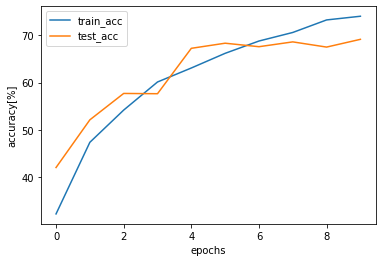

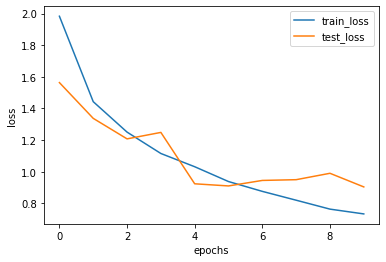

09/16 12:43:33 PM epoch 11
09/16 12:43:33 PM alpha tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000, 0.4705, 0.2366, 0.1885, 0.1637, 0.0193],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.5295, 0.4997, 0.2480, 0.3270, 0.0199],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.2636, 0.1913, 0.1514, 0.0217],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3721, 0.2021, 0.7805],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1558, 0.1453],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0133],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
09/16 12:43:33 PM train 000 8.770757e-01 70.312500 96.875000
09/16 12:43:51 PM train 100 6.901883e-01 75.479579 98.530322
09/16 12:44:01 PM train_acc 75.600000
09/16 12:44:01 PM valid 00

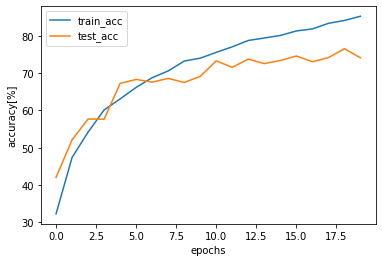

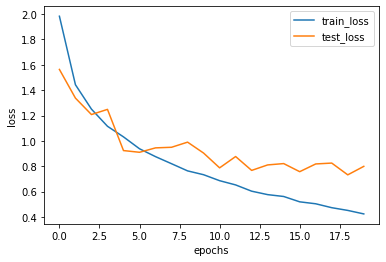

09/16 12:48:25 PM epoch 21
09/16 12:48:25 PM alpha tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000, 0.9226, 0.1703, 0.1530, 0.1017, 0.0067],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0774, 0.6331, 0.4587, 0.6580, 0.0072],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1966, 0.1545, 0.0787, 0.0069],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.2338, 0.0846, 0.9635],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0769, 0.0120],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0037],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
09/16 12:48:25 PM train 000 3.877784e-01 84.375000 100.000000
09/16 12:48:43 PM train 100 3.985823e-01 85.922030 99.628713
09/16 12:48:53 PM train_acc 85.510000
09/16 12:48:53 PM valid 0

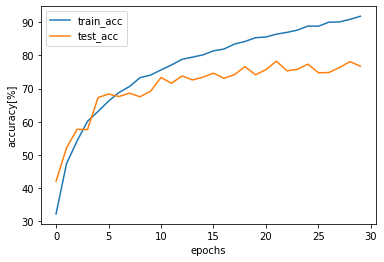

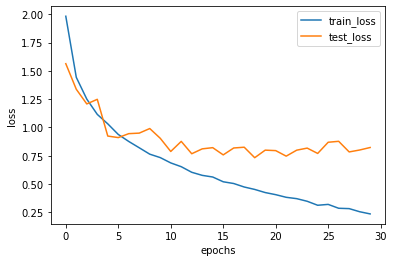

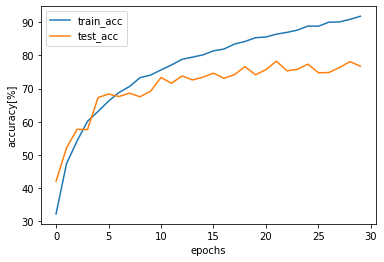

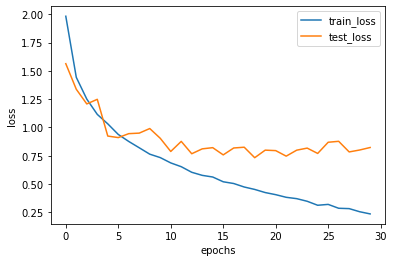

Experiment dir : networkx_test_evaluate-2020-09-16_21-53-21
09/16 12:53:21 PM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=30, graph=<networkx.classes.digraph.DiGraph object at 0x7f47ecacca58>, lr=0.01, lr_alpha=0.005, momentum=0.9, report=100, save='networkx_test_evaluate-2020-09-16_21-53-21', seed=41, test_size=5000, train_size=10000, valid_size=10000)
09/16 12:53:21 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
09/16 12:53:23 PM epoch 1
09/16 12:53:23 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]

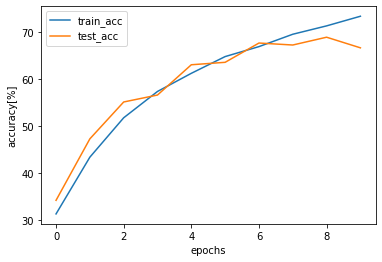

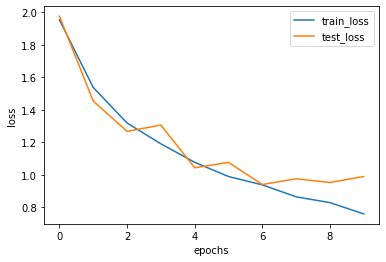

09/16 12:57:40 PM epoch 11
09/16 12:57:40 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/16 12:57:40 PM train 000 7.265587e-01 78.125000 96.875000
09/16 12:57:55 PM train 100 7.510569e-01 73.685025 98.236386
09/16 12:58:04 PM train_acc 74.060000
09/16 12:58:04 PM valid 000 7.318912e-01 73.437500 100.000000
09/16 12:58:05 PM valid_acc 70.060000
09/16 12:58:05 PM epoch 12
09/16 12:58:05 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0

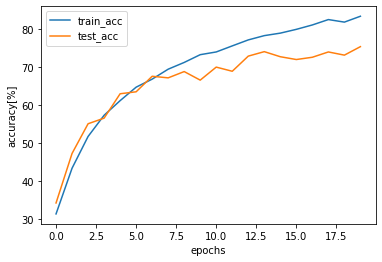

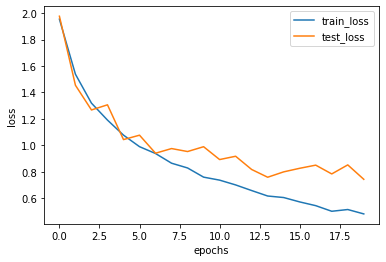

09/16 01:01:55 PM epoch 21
09/16 01:01:55 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/16 01:01:55 PM train 000 5.112659e-01 76.562500 98.437500
09/16 01:02:10 PM train 100 4.257504e-01 84.947401 99.613243
09/16 01:02:19 PM train_acc 84.570000
09/16 01:02:19 PM valid 000 7.853553e-01 70.312500 98.437500
09/16 01:02:20 PM valid_acc 75.080000
09/16 01:02:20 PM epoch 22
09/16 01:02:20 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0.

Traceback (most recent call last):


09/16 01:05:08 PM train 100 3.261254e-01 88.350866 99.845297
09/16 01:05:16 PM train_acc 88.620000
09/16 01:05:16 PM valid 000 5.091376e-01 82.812500 100.000000
09/16 01:05:18 PM valid_acc 78.240000
09/16 01:05:18 PM epoch 29
09/16 01:05:18 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/16 01:05:18 PM train 000 2.863045e-01 93.750000 100.000000
09/16 01:05:33 PM train 100 2.978539e-01 89.449257 99.860767
09/16 01:05:42 PM train_acc 88.870000
09/16 01:05:42 PM valid 000 7.836611e-01 73.437500 98.437500
09/16 01:05:43 PM valid_acc 77.260000
09/16 01:05:43 PM epoch 30
09/16 01:05:43 PM alpha tensor(

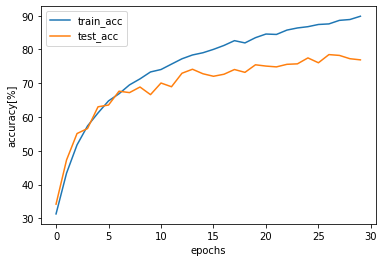

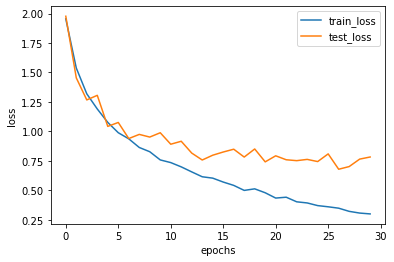

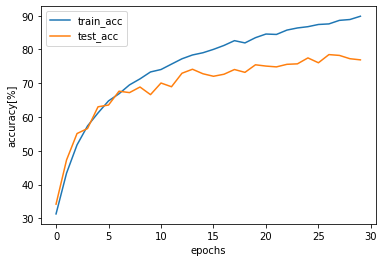

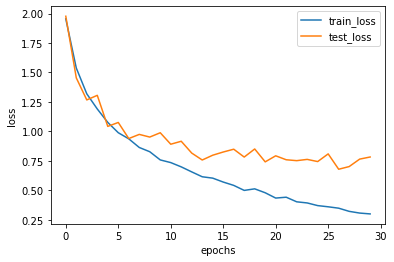

In [ ]:
if __name__ == '__main__':
  model = \
  main(save="networkx_test_search", lr=0.01, momentum=0.9, lr_alpha=0.005, epochs=30, 
      train_size=10000, valid_size=10000, test_size=5000, batch_size=64, 
      seed=41, report=100, checkpoint=10, dir="", graph=None)
  sampler : ArchitectureSampler = ForwardSampler()
  graph = model.sampled_graph(sampler)
  main(save="networkx_test_evaluate", lr=0.01, momentum=0.9, lr_alpha=0.005, epochs=30, 
      train_size=10000, valid_size=10000, test_size=5000, batch_size=64, 
      seed=41, report=100, checkpoint=10, dir="", graph=graph)

# exp

TODO
- watch model size, memory
- early stopping